In [1]:
import numpy as np
import pandas as pd
import random

df = pd.read_csv("flaredown_trackable_data_080316.csv")
df['checkin_date'] = pd.to_datetime(df['checkin_date'])

print df.head()

   user_id checkin_date  trackable_id trackable_type      trackable_name  \
0        3   2015-11-26          1069      Condition  Ulcerative colitis   
1        6   2015-11-26          1069      Condition  Ulcerative colitis   
2        8   2015-06-22           269      Condition     Crohn's disease   
3        9   2015-05-26           421      Condition       Gastroparesis   
4        9   2015-05-26           152        Symptom              Nausea   

  trackable_value  
0               0  
1               0  
2               3  
3               2  
4               1  


In [4]:
#types of trackables :
print set(df['trackable_type'])

set(['Tag', 'Symptom', 'Condition', 'Treatment'])


In [3]:
#It looks like some users have created an account without using the app for more than a single entry.  So lets remove them.
by_user = df.groupby('user_id')
df = by_user.filter(lambda x: len(x) > 1)

### What are the most well represented conditions?

In [3]:
df_conditions = df[df['trackable_type'] == 'Condition']
print df_conditions['trackable_name'].value_counts().head(20)

print "Distinct Conditions : " + str(len(set(df_conditions['trackable_name'])))

Depression                  4790
Anxiety                     4028
Fibromyalgia                3577
Chronic fatigue syndrome    3220
Migraine                    2403
Headaches                   1553
Irritable bowel syndrome    1466
Endometriosis               1379
Ehlers-Danlos syndrome      1281
Asthma                      1173
Idiopathic hypersomnia      1039
Hypothyroidism               922
Fatigue                      911
Dysautonomia                 880
IBS                          861
Crohn's disease              858
Lyme disease                 812
Ulcerative colitis           801
Allergies                    792
joint pain                   785
Name: trackable_name, dtype: int64
Distinct Conditions : 882


### Since Depression is well represented in the data, how many individual users are reporting depression?

In [4]:
just_depression = df[df['trackable_name'] == 'Depression']
depression_by_user = just_depression.groupby('user_id')
print len(depression_by_user)

547


### Are any of the Conditions heavily correlated?

In [5]:
df_conditions = df[df['trackable_type'] == 'Condition']

df_conditions = df_conditions.drop('trackable_id',1)
df_conditions = df_conditions.drop('trackable_type',1)
df_conditions = df_conditions.drop('checkin_date',1)
df_conditions = df_conditions.drop('trackable_value',1)
df_conditions = pd.get_dummies(df_conditions)
conditions_by_user = df_conditions.groupby('user_id').sum()

corrs = conditions_by_user.corr()

#print just the substantial corrs (There are still a lot of them) #TODO filter by pvalue
#for name, values in corrs.iteritems():
#    for value in values:
#        if value > 0.9 and value != 1:
#            print name + str(value)

A lot of the conditions are correlated.  Enough that they fill up the notebook pretty quickly.  Uncomment above to see them

### Are people finding relief from these conditions?
Lets grab users that have been logging for a while, and look at their trends.  The people that have been logging a long time will hopefully give us a clearer trend that we can read from a graph.  We will show how they rated their conditions over the duration of their time logging.

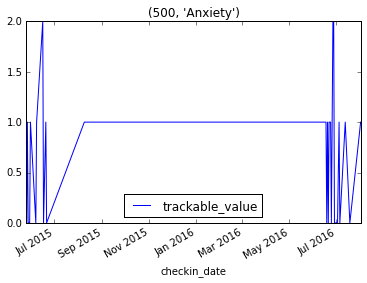

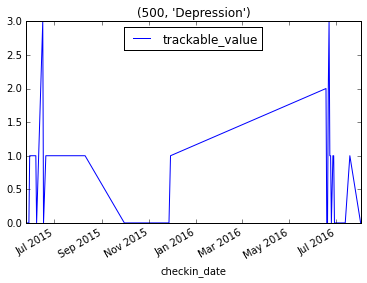

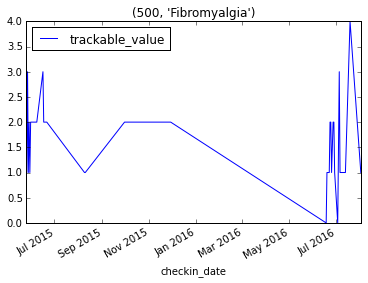

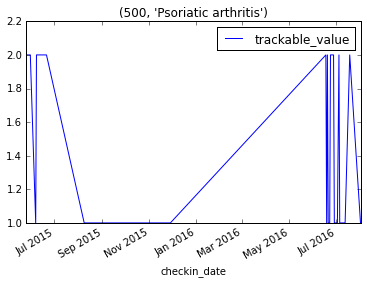

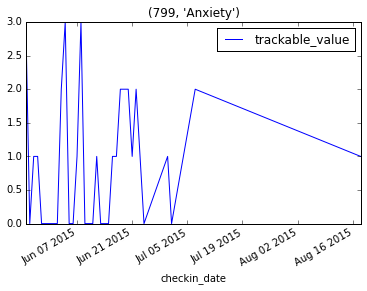

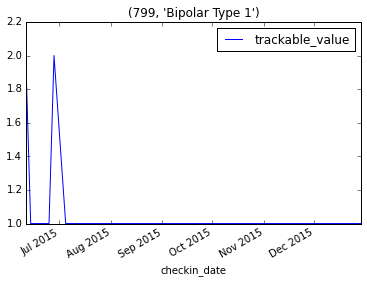

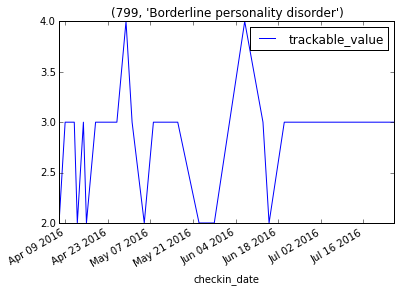

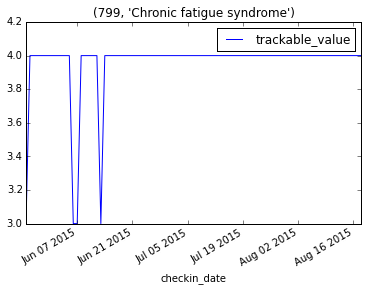

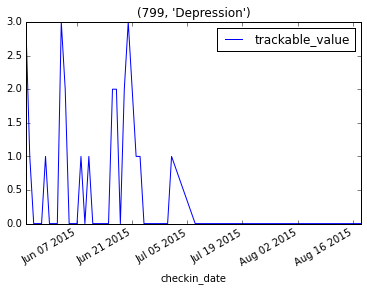

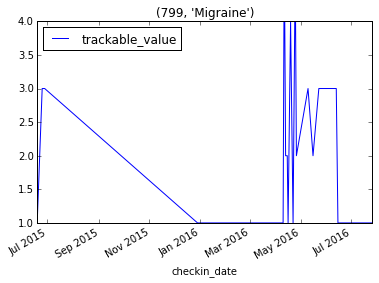

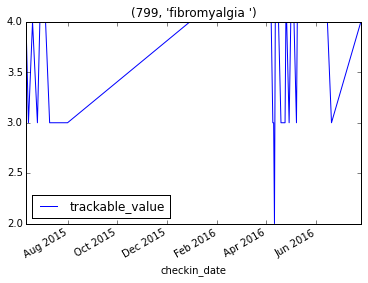

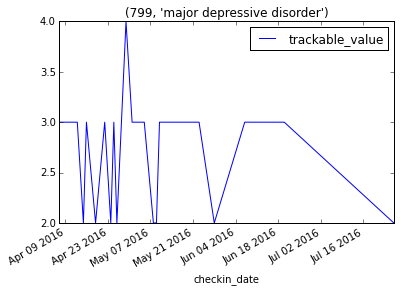

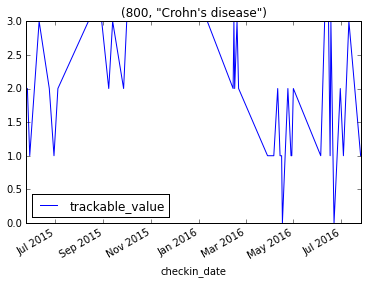

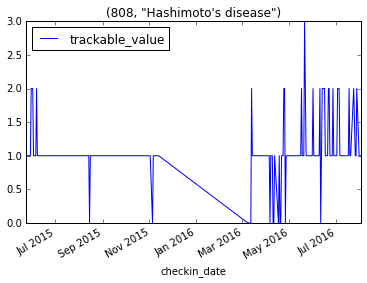

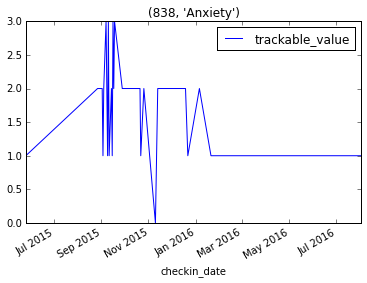

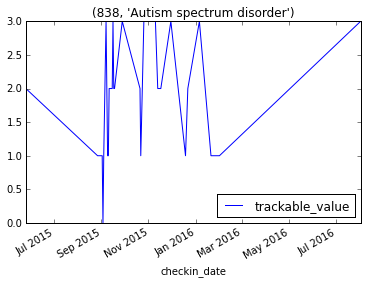

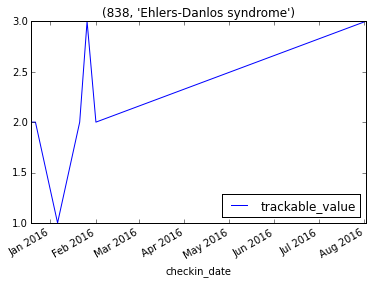

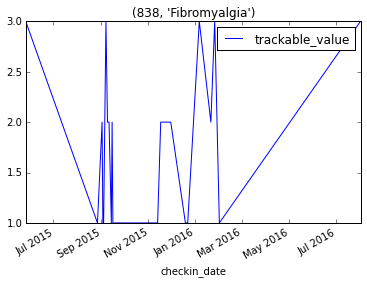

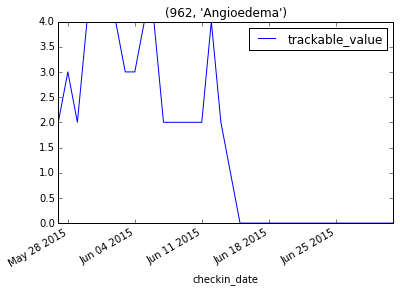

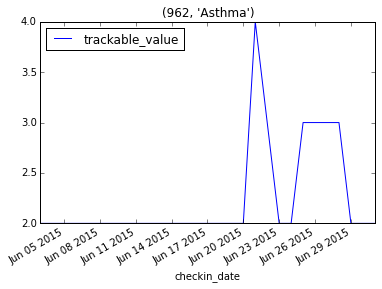

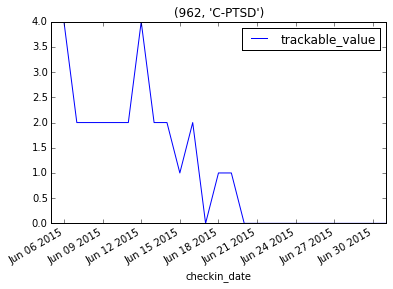

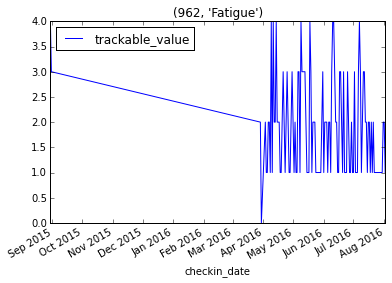

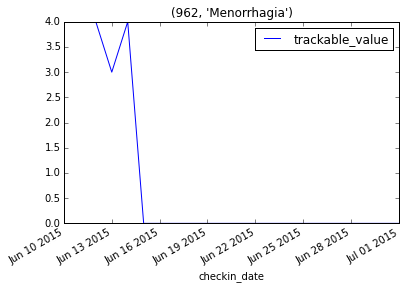

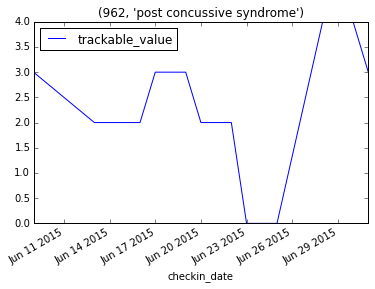

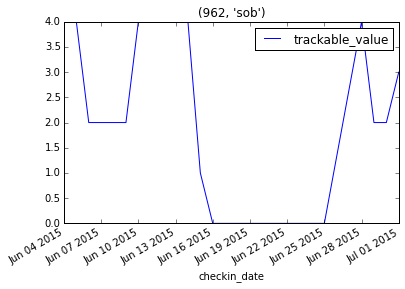

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def find_duration(x):
    return x.values[len(x)-1] - x.values[0]

df_with_duration = df[df['trackable_type'] == 'Condition']
df_with_duration['duration'] = df.groupby('user_id')['checkin_date'].transform(find_duration)
df_with_duration['duration'] = pd.to_numeric(df_with_duration['duration'])
#df_with_duration['trackable_value'] = pd.to_numeric(df['trackable_value'])
df_with_duration = df_with_duration.convert_objects(convert_numeric=True)

df_with_duration = df_with_duration.sort('duration', ascending=False)
just_high_duration = df_with_duration[df_with_duration['duration'] > 36500000000000000]

for i, group in just_high_duration.groupby(['user_id','trackable_name']):
    if (len(group) > 1 and len(group) < 200):  #filtering the 200's because they aren't super legible anyways, take this line out for a more complete look
        plt.figure()
        group.plot(x='checkin_date', y='trackable_value', title=str(i))

### How complete is the data we are getting from each user?

This is a very new app, in fact it just left beta.  Users haven't been using it for very long.  Let's take a look at just how long, and how many days they tend to have logged during that time.

In [46]:

print "Average duration that users logged : " + str(df_with_duration['duration'].mean() / 86400000000000) + " days"
print "Max duration that a user logged : " + str(df_with_duration['duration'].max() / 86400000000000) + " days\n"


def count_days(x):
    return len(set(x))

df_with_count = df.copy()
df_with_count['count'] = df.groupby('user_id')['checkin_date'].transform(count_days)
df_with_count['count'] = pd.to_numeric(df_with_count['count'])
print "Average number of tracked days per user : " + str(df_with_count['count'].mean())
print "Max number of tracked days by a user : " + str(df_with_count['count'].max())

Average duration that users logged : 176.287071059 days
Max duration that a user logged : 434 days

Average number of tracked days per user : 157.946801867
Max number of tracked days by a user : 429


### How consistently are people logging?

We know that people won't log every day, but will they once a week?  Once a month?  Randomly?  We could probably measure the entropy on the date series, but I think the easiest way to look at this will be to just plot the days that a bunch of random users checked in, and visually observe if they follow consistent patterns.

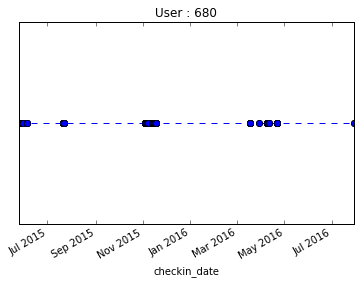

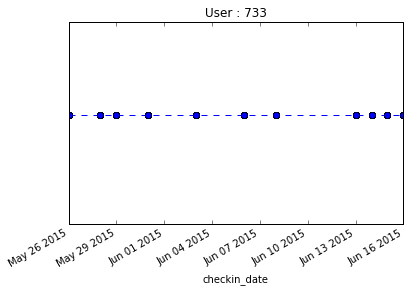

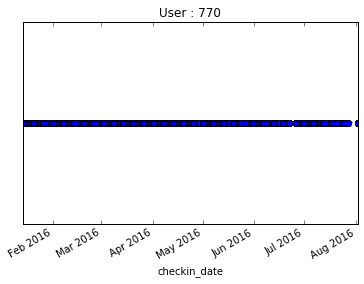

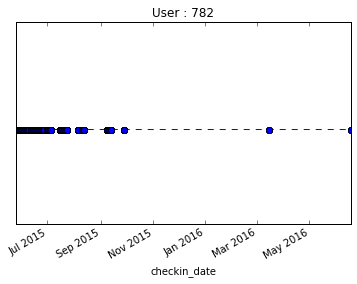

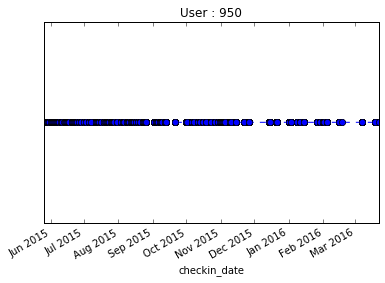

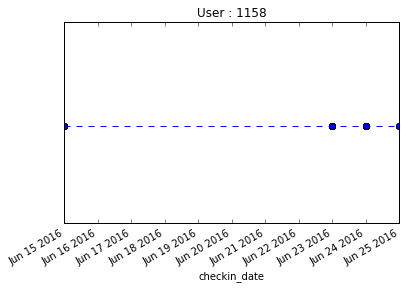

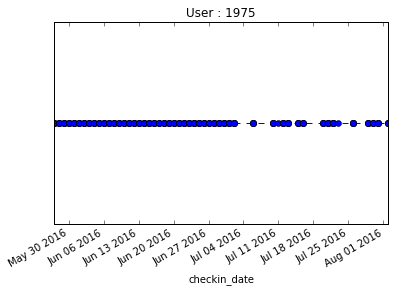

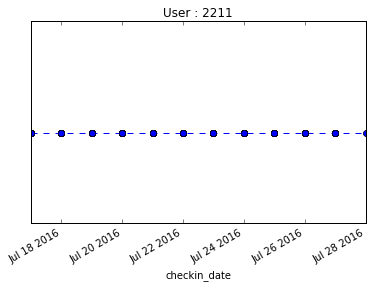

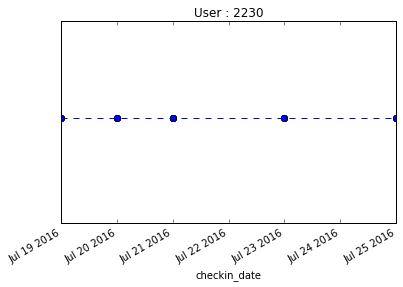

In [45]:
#grab a few random users
random.seed(0) #I want random users, but I want us all to see the same ones
random_ids = random.sample(set(df['user_id']), 20)
random_users = df[df['user_id'].isin(random_ids)]

plt.figure()

for i, group in random_users.groupby(['user_id']):
    #just ignore users if they've only logged a few days, because we can't see a pattern there
    if len(set(group['checkin_date'])) > 3:
        ax = group.plot(x='checkin_date', y='user_id', title="User : "+str(i), linestyle='--', marker='o', color='b', legend=False)
        ax.yaxis.set_visible(False)


Let's just take a moment to give a shout out to user 2211.

It may be nice to run this again after the Android app is released and see if there is an improvement.

### What percentage of tags are the defaults?

Tags are meant to be somewhat free-form, but we suspect that users are just using the default tags.  Lets see what tags are being used.

The default tags are : tired,stressed,had sex,ate breakfast,good sleep,gluten,alcohol,dairy,walked,period

In [10]:
df_tags = df[df['trackable_type'] == 'Tag']
print "the top 20 tags are"
print df_tags['trackable_name'].value_counts().head(20)

default_tags = ["tired","stressed","had sex","ate breakfast","good sleep","gluten","alcohol","dairy","walked","period"]
tag_counts = df_tags['trackable_name'].value_counts()

#this is 0:10 at the moment, but lets grab the indices just in case they change later
default_tag_indices = tag_counts.reset_index()
default_tag_indices = default_tag_indices[default_tag_indices['index'].isin(default_tags)].index

print "\nNumber of times default tags used : " + str(tag_counts.loc[default_tags].sum())
print "Total tags used: " + str(tag_counts.sum())
print "Percent of tags used that are default : %" + str(float(tag_counts.loc[default_tags].sum()) / float(tag_counts.sum()) * 100.0) 

#remove the tags only seen once
df_tag_counts = tag_counts.reset_index()
df_tag_counts.columns = ['tag','count']
df_tag_counts = df_tag_counts[df_tag_counts['count'] > 1]
print "\nWith tags only seen once removed, there are " + str(df_tag_counts['count'].sum()) + " total tags"


the top 20 tags are
tired                 3639
stressed              1626
ate breakfast         1299
good sleep             808
period                 668
dairy                  668
gluten                 639
walked                 614
alcohol                488
had sex                478
happy                  268
Went to work           263
exercise               253
hiking                 232
Superlong nap          222
video games            181
slept in               175
day improved           173
social interaction     166
exhausted              160
Name: trackable_name, dtype: int64

Number of times default tags used : 10927
Total tags used: 44860
Percent of tags used that are default : %24.358002675

With tags only seen once removed, there are 43268 total tags


### How many people are using some of these tags?

I see lots of superlong naps.  That seems rather specific.  Is that all one user?

In [104]:
print "unique users taking Superlong naps " + str(len(set(df_tags[df_tags['trackable_name'] == 'Superlong nap']['user_id'])))
print "unique users exhausted " + str(len(set(df_tags[df_tags['trackable_name'] == 'exhausted']['user_id'])))
print "unique users hiking " + str(len(set(df_tags[df_tags['trackable_name'] == 'hiking']['user_id'])))

unique users taking Superlong naps 90
unique users exhausted 44
unique users hiking 76


### How often are conditions tied to other conditions?

Depression and anxiety come up a lot.  It seems like depression and anxiety may be linked to other conditions, and if they are being caused by other conditions they may need to be treated differently in some analysis.  For example if depression and Fibromyalgia appear together, is the depression really a seperate condition, or just a symptom of the Fibromyalgia?

In [48]:
def countConcurrentCondtions(condition):
    affected_users = df[df['trackable_type'] == 'Condition']
    affected_users = affected_users.groupby('user_id').filter(lambda x: condition in x['trackable_name'].values)
    condition_counts = affected_users.groupby('user_id')['trackable_name'].apply(lambda x: len(x.unique()))
    return float(condition_counts.sum()) / float(len(condition_counts))
    
#add the concurency counts to a dataframe so we can order it and print the top
concurrency_counts = pd.DataFrame(columns=['Condition', 'average_concurrent_conditions'])
for condition in set(df[df['trackable_type'] == 'Condition']['trackable_name']):
    average = countConcurrentCondtions(condition)
    concurrency_counts = concurrency_counts.append({'Condition' : condition, 'average_concurrent_conditions' : average}, ignore_index=True)
concurrency_counts = concurrency_counts.sort_values(by=['average_concurrent_conditions'],ascending=False)
print concurrency_counts.head(15)
print "mean number of concurrent conditions : " + str(concurrency_counts['average_concurrent_conditions'].mean())
print "mean number of concurrent conditions that occurr with depression: " + str(concurrency_counts[concurrency_counts['Condition'] == "Depression"]['average_concurrent_conditions'].values)
print "mean number of concurrent conditions that occurr with anxiety: " + str(concurrency_counts[concurrency_counts['Condition'] == "Anxiety"]['average_concurrent_conditions'].values)

                            Condition  average_concurrent_conditions
179                        Dark Triad                           31.0
428     Schizoid personality disorder                           30.0
11   Common variable immunodeficiency                           30.0
252              Deep vein thrombosis                           30.0
86              Mitral valve prolapse                           30.0
513                         Epistaxis                           29.5
82            Blood clotting disorder                           29.5
160               Achilles Tendonitis                           28.0
190           Orthostatic hypotension                           25.0
371                           fatique                           25.0
562                        Oral sores                           23.0
622                     genital sores                           23.0
507                       psychopathy                           23.0
586                          wheez

We can see here that some users are logging a very large number of different conditions.  A quick check shows that only one person is registering 'Dark Triad', and since they log a lot of conditions, the average concurrent conditions for 'Dark Triad' is very high.  It may be more informative if we filter out conditions that are only represented a few times.

In [54]:
concurrency_counts = pd.DataFrame(columns=['Condition', 'average_concurrent_conditions'])
for condition in set(df[df['trackable_type'] == 'Condition']['trackable_name']):
    if len(set(df[df['trackable_name'] == condition]['user_id'])) > 3:
        average = countConcurrentCondtions(condition)
        concurrency_counts = concurrency_counts.append({'Condition' : condition, 'average_concurrent_conditions' : average}, ignore_index=True)
concurrency_counts = concurrency_counts.sort_values(by=['average_concurrent_conditions'],ascending=False)
print concurrency_counts.head(20)
print "mean number of concurrent conditions : " + str(concurrency_counts['average_concurrent_conditions'].mean())
print "mean number of concurrent conditions that occurr with depression: " + str(concurrency_counts[concurrency_counts['Condition'] == "Depression"]['average_concurrent_conditions'].values)
print "mean number of concurrent conditions that occurr with anxiety: " + str(concurrency_counts[concurrency_counts['Condition'] == "Anxiety"]['average_concurrent_conditions'].values)

                         Condition  average_concurrent_conditions
135                        fatique                      25.000000
179                         Hunger                      19.500000
219           Urinary incontinence                      18.777778
143                 social anxiety                      18.500000
205                    Inattention                      18.000000
228                           Cold                      17.000000
28              Seasonal Allergies                      16.333333
53              Neurogenic Bladder                      16.200000
251                         Thirst                      16.000000
104                   irritability                      15.375000
192                Urinary Urgency                      15.250000
94                      Vulvodynia                      15.000000
185                      Dry mouth                      14.500000
308                     Groin Pain                      14.250000
158       

In [31]:
df['condition_count'] = df[df['trackable_type'] == 'Condition'].groupby('user_id')['trackable_name'].transform('nunique')
print "mean number of conditions per user " + str(np.mean(df['condition_count']))
print "max number of conditions reported by one user " + str(np.max(df['condition_count']))

df['symptom_count'] = df[df['trackable_type'] == 'Symptom'].groupby('user_id')['trackable_name'].transform('nunique')
print "mean number of symptoms per user " + str(np.mean(df['symptom_count']))
print "max number of symptoms reported by one user " + str(np.max(df['symptom_count']))

df['treatment_count'] = df[df['trackable_type'] == 'Treatment'].groupby('user_id')['trackable_name'].transform('nunique')
print "mean number of treatments per user " + str(np.mean(df['treatment_count']))
print "max number of treatments reported by one user " + str(np.max(df['treatment_count']))

df['tag_count'] = df[df['trackable_type'] == 'Tag'].groupby('user_id')['trackable_name'].transform('nunique')
print "mean number of tags per user " + str(np.mean(df['tag_count']))
print "max number of tags reported by one user " + str(np.max(df['tag_count']))

#print "the conditions reported by the max reported conditions user : "
#most_conditions_user = df.iloc[df['condition_count'].idxmax()]['user_id']
#print set(df[(df['user_id'] == most_conditions_user) & (df['trackable_type'] == 'Condition')]['trackable_name']) 

mean number of conditions per user 10.2950046406
max number of conditions reported by one user 31.0
mean number of symptoms per user 29.9288875002
max number of symptoms reported by one user 160.0
mean number of treatments per user 20.0494657971
max number of treatments reported by one user 54.0
mean number of tags per user 129.698324271
max number of tags reported by one user 623.0
